<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# Conditional DCGAN

In [2]:
import torch
from torch import nn
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from svlearn_gan import config , Task
from svlearn_gan.dcgan_models import DigitGenerator
from svlearn_gan.conditional_dcgan import ConditionalGenerator
from svlearn_gan.dcgan_datasets import load_mnist_dataset
from svlearn_gan.gan_trainer import load_checkpoint

In [3]:
task = Task.MNIST.value
data_dir = config[task]['data']
results_dir=config[task]['results']


In [4]:
# Number of workers for dataloader
#workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Global variables
# Number of channels in the training images. For color images this is 3
nc = config[task]['num_channels']

# Size of z latent vector (i.e. size of generator input)
nz = config[task]['nz']

# Size of feature maps in generator
ngf = config[task]['ngf']

# Size of feature maps in discriminator
ndf = config[task]['ndf']

# number of classes of training images
num_classes = config[task]['num_classes']

# Decide which device we want to run on
device =  torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")   
device = torch.device("mps") if torch.backends.mps.is_available() else device


In [5]:
dataset = load_mnist_dataset()

# Create the dataloader
if batch_size == -1:
        batch_size = len(dataset)
        
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

In [6]:
classes = dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
# Create the Generator and Discriminator
generator = DigitGenerator(nz, ngf, nc).to(device)
netG = ConditionalGenerator(generator, num_classes).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

Display sample images along with their labels

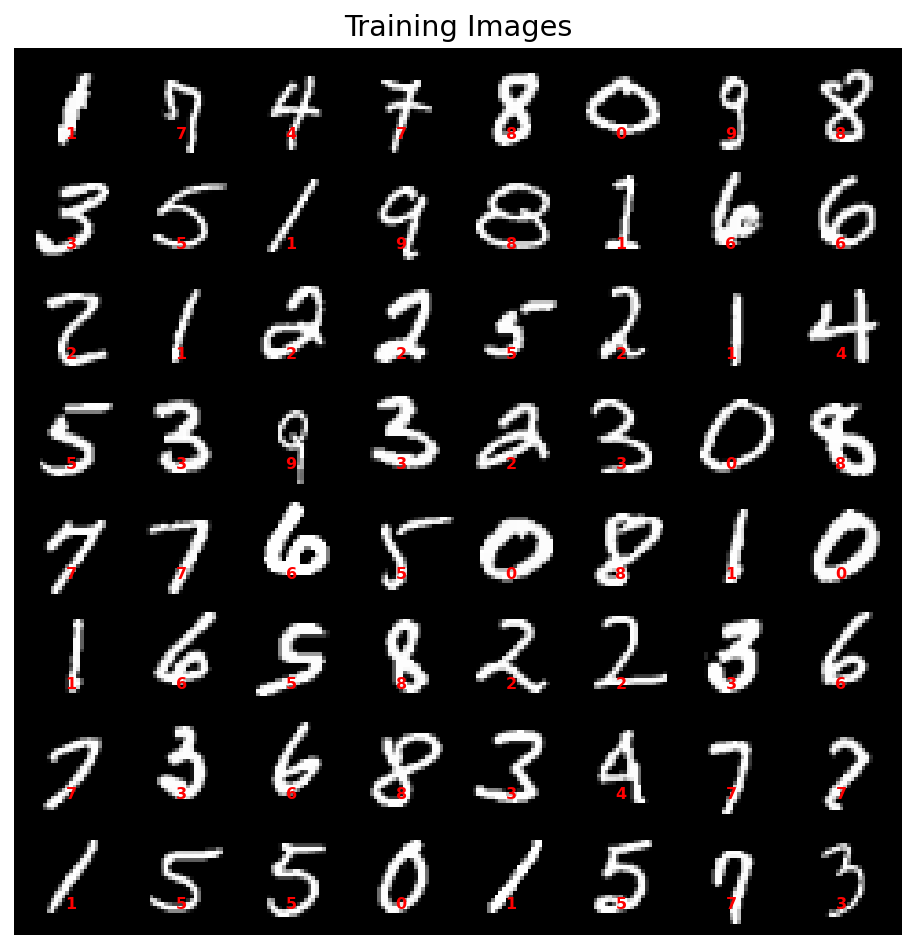

In [8]:

# Plot some training images
# Get a batch of images and labels
real_batch = next(iter(dataloader))
images, labels = real_batch[0].to(device), real_batch[1].cpu().numpy()  # Convert labels to numpy array for easier handling

# Create a grid of images
grid = vutils.make_grid(images[:64], padding=2, normalize=True)
grid = np.transpose(grid.cpu().numpy(), (1, 2, 0))  # Transpose to (H, W, C) format for plotting

# Plot the grid
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)

# Add labels to each image
grid_size = int(np.sqrt(64))  # Assuming a 8x8 grid for 64 images
img_size = grid.shape[0] // grid_size  # Calculate size of each image in the grid
for i in range(64):
    row = i // grid_size
    col = i % grid_size
    # Position text at the bottom center of each image
    plt.text(col * img_size + img_size / 2, row * img_size + img_size - 5,
             str(classes[labels[i]][0]), ha="center", va="bottom", color="red", fontsize=8, weight='bold')

plt.show()

Load the already trained conditional DCGAN

In [9]:
checkpoint_generator_file = f'{results_dir}/conditional_generator.pt'
load_checkpoint(netG , checkpoint_generator_file)


ConditionalGenerator(
  (generator): DigitGenerator(
    (first_layer): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (subsequent_layers): Sequential(
      (0): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(56, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (9): Tanh()
    )
    (main): Sequential(
      (0): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (1): Sequential(
        (0): Batch

In [10]:
gen_checkpoint = torch.load(f'{results_dir}/conditional_generator.pt')
results = gen_checkpoint["results"]
epoch = gen_checkpoint["epoch"]
print(f'Epoch with best metrics is {epoch}')

Epoch with best metrics is 180


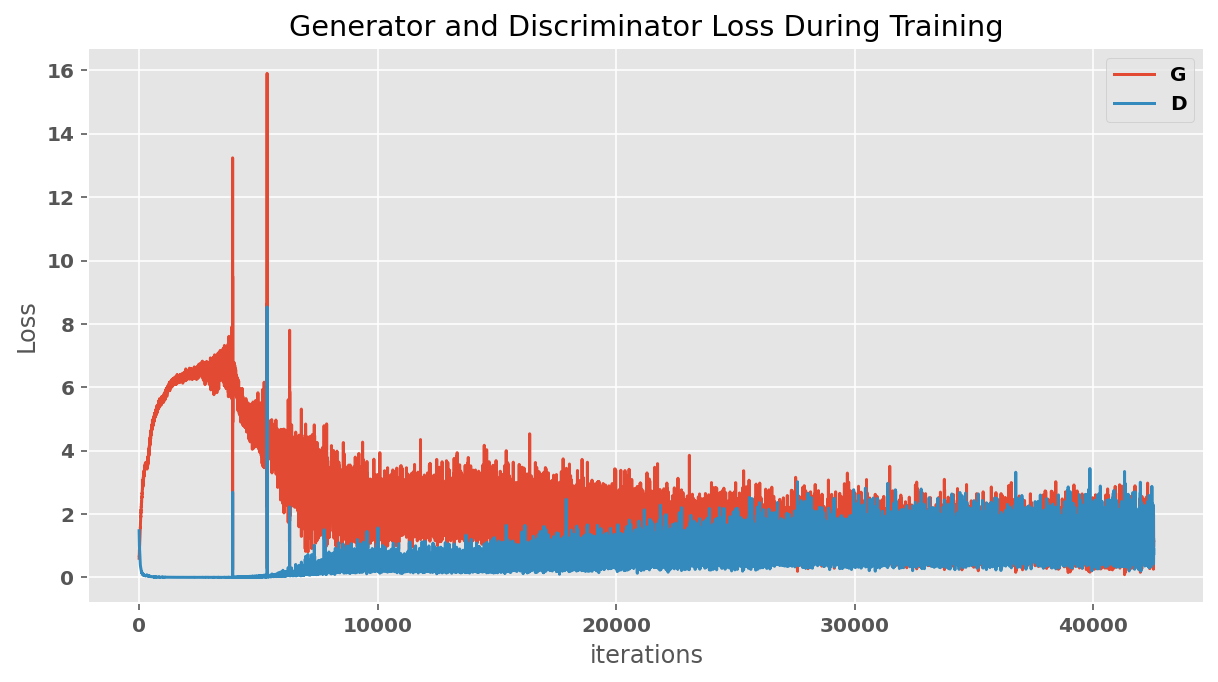

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(results["gen loss"],label="G")
plt.plot(results["dis loss"],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
netG.eval()

ConditionalGenerator(
  (generator): DigitGenerator(
    (first_layer): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (subsequent_layers): Sequential(
      (0): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(56, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (9): Tanh()
    )
    (main): Sequential(
      (0): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (1): Sequential(
        (0): Batch

Add image labels of 3 to the noise to generate images with "3" conditioning

In [13]:
# Size of z latent vector (i.e. size of generator input)
nz = 100
# size of the test batch
test_batch_size = 16
# Create batch of latent vectors that we will use to visualize the generator
noise = torch.randn(test_batch_size, nz, 1, 1, device=device)
#image_labels = torch.zeros(test_batch_size, dtype=torch.long).to(device)
image_labels = torch.full((test_batch_size,), 3, dtype=torch.long).to(device)
with torch.no_grad():
    fake = netG(noise, image_labels).cpu()
image_grid = vutils.make_grid(fake, padding=2, normalize=True)

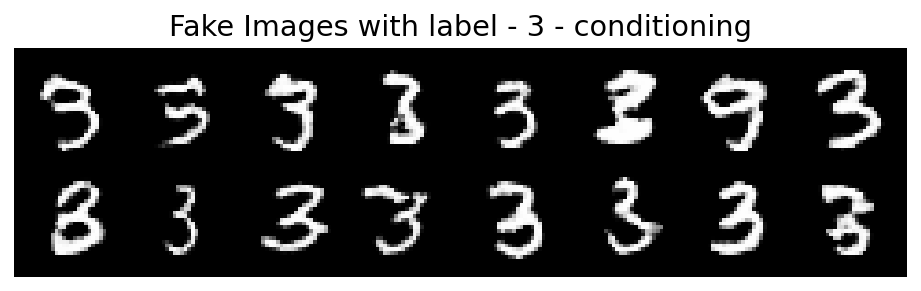

In [14]:
# Plot the fake images generated from noise
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images with label - 3 - conditioning")
plt.imshow(np.transpose(image_grid,(1,2,0)))
plt.show()

Add random image labels to the noise vector to generate images with the specific conditioning

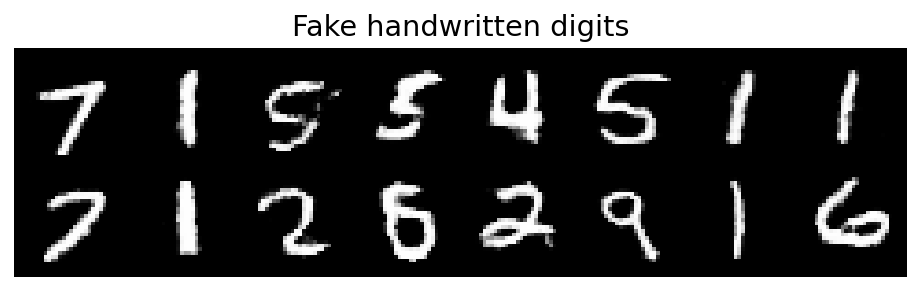

tensor([7, 1, 5, 5, 4, 5, 1, 1, 7, 1, 2, 5, 2, 9, 1, 6], device='mps:0')

In [15]:
# Create batch of latent vectors that we will use to visualize the generator
noise = torch.randn(test_batch_size, nz, 1, 1, device=device)
image_labels = torch.randint(0, 10, (test_batch_size,1), dtype=torch.long).to(device).view(-1)


with torch.no_grad():
    fake = netG(noise, image_labels).cpu()
image_grid = vutils.make_grid(fake, padding=2, normalize=True)

# Plot the fake images generated from noise
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake handwritten digits")
plt.imshow(np.transpose(image_grid,(1,2,0)))
plt.show()
image_labels